In [26]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [27]:
import os
import cv2
import numpy as np

labels = {'PNEUMONIA': 0, 'NORMAL': 1}  # Using dictionary for clarity
img_size = 200

def get_training_data(data_dir):
    images = [] 
    labels_list = []
    for label, label_num in labels.items(): 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                labels_list.append(label_num)
            except Exception as e:
                print(e)
    return np.array(images), np.array(labels_list)


In [28]:
train_images, train_labels = get_training_data('C:/Users/Dell/Desktop/Pneu_dataset/chest_xray/train')
test_images, test_labels = get_training_data('C:/Users/Dell/Desktop/Pneu_dataset/chest_xray/test')
val_images, val_labels = get_training_data('C:/Users/Dell/Desktop/Pneu_dataset/chest_xray/val')


In [30]:
pnenumonia = 0 
normal = 0 

for label in train_labels:
    if label == 0:
        pnenumonia += 1
    else:
        normal += 1

print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia - normal)


Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


PNEUMONIA


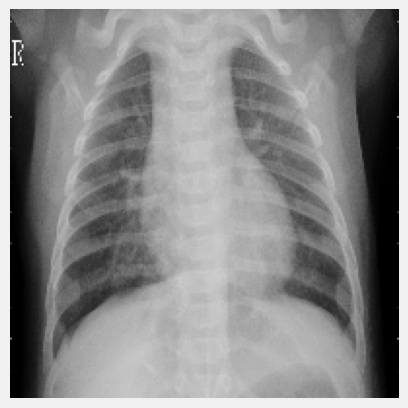

In [36]:
labels = ['PNEUMONIA', 'NORMAL']
plt.imshow(train_images[1], cmap='gray')
plt.axis('off')
print(labels[train_labels[1]])


In [39]:
X = []
y = []

# For train data
for feature, label in zip(train_images, train_labels):
    X.append(feature)
    y.append(label)

# For test data
for feature, label in zip(test_images, test_labels):
    X.append(feature)
    y.append(label)
    
# For validation data
for feature, label in zip(val_images, val_labels):
    X.append(feature)
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape data for deep learning
X = X.reshape(-1, img_size, img_size, 1)

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)


In [40]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [41]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [42]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 256)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 100, 100, 256)     400       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [44]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15


375/375 [==============================] - 607s 2s/step - loss: 0.6239 - acc: 0.7056 - val_loss: 0.5972 - val_acc: 0.7407
Epoch 2/15
375/375 [==============================] - 582s 2s/step - loss: 0.5040 - acc: 0.7342 - val_loss: 0.4617 - val_acc: 0.7524
Epoch 3/15
375/375 [==============================] - 614s 2s/step - loss: 0.4402 - acc: 0.7766 - val_loss: 0.3435 - val_acc: 0.8581
Epoch 4/15
375/375 [==============================] - 567s 2s/step - loss: 0.4065 - acc: 0.8014 - val_loss: 0.3082 - val_acc: 0.8591
Epoch 5/15
375/375 [==============================] - 560s 1s/step - loss: 0.3671 - acc: 0.8369 - val_loss: 0.3653 - val_acc: 0.7951
Epoch 6/15
375/375 [==============================] - 560s 1s/step - loss: 0.3547 - acc: 0.8428 - val_loss: 0.2529 - val_acc: 0.8954
Epoch 7/15
375/375 [==============================] - 565s 2s/step - loss: 0.3092 - acc: 0.8631 - val_loss: 0.2362 - val_acc: 0.8975
Epoch 8/15
375/375 [==============================] - 559s 1s/step 

In [45]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 29s 774ms/step - loss: 0.2674 - acc: 0.8823


[0.2673543095588684, 0.88225257396698]

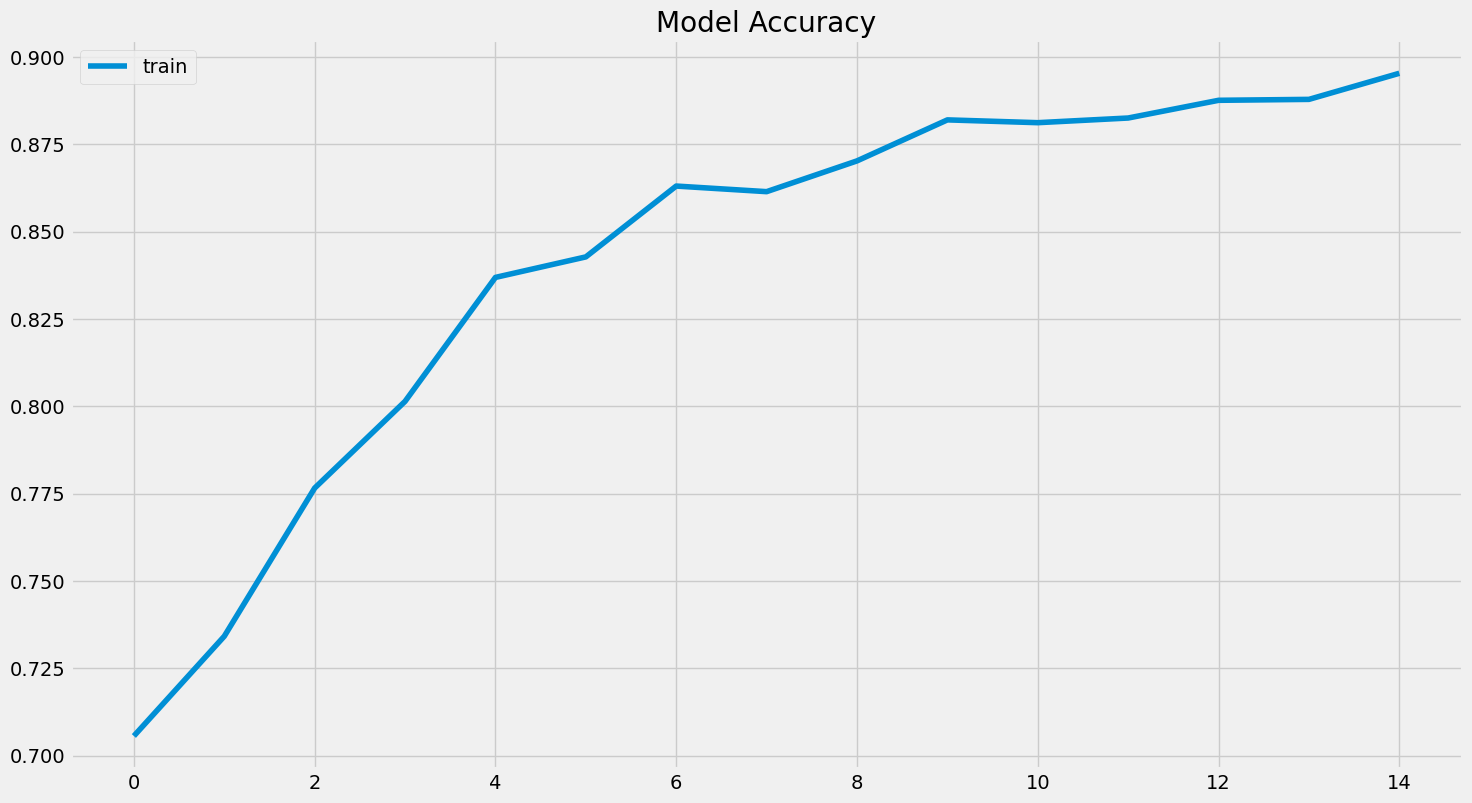

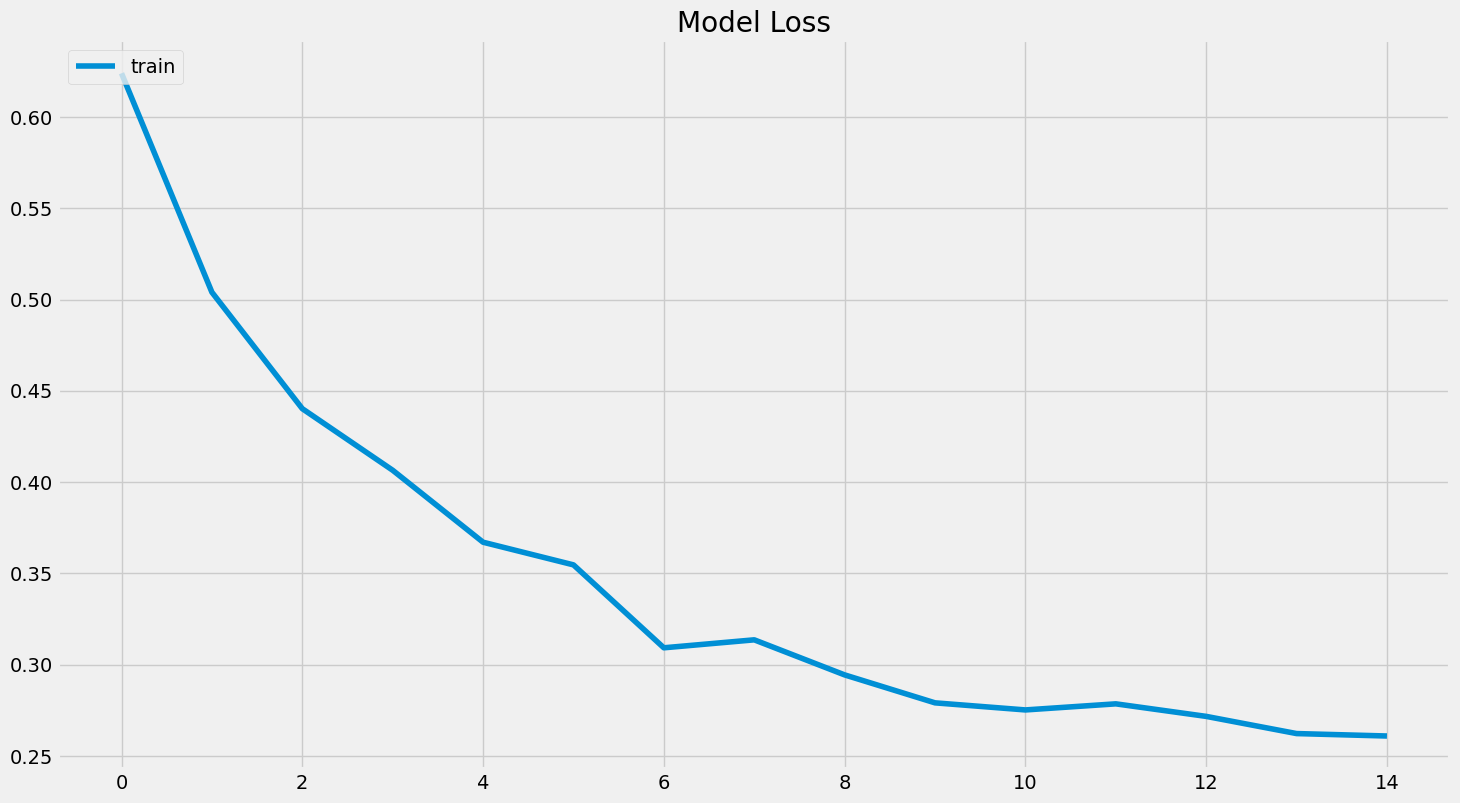

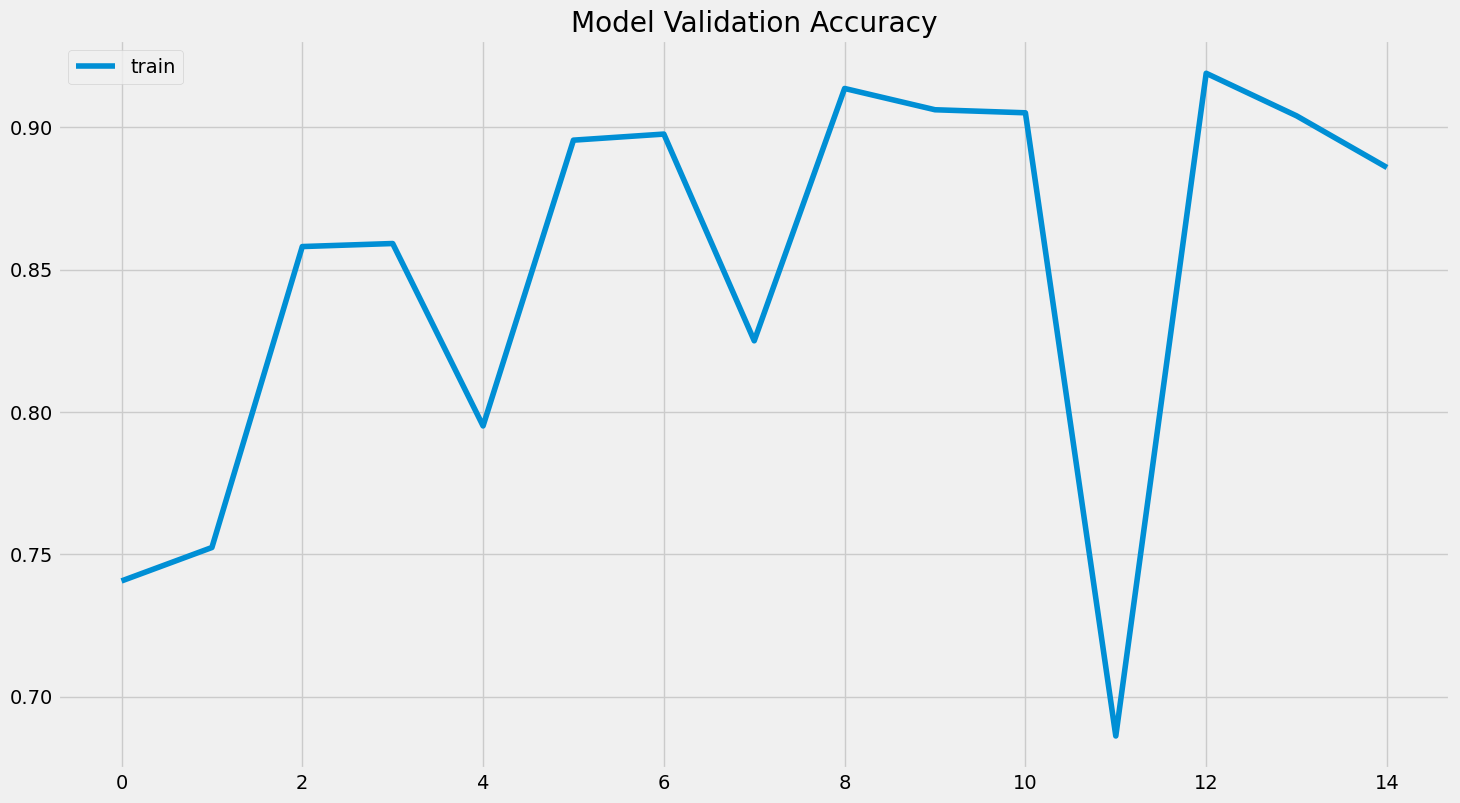

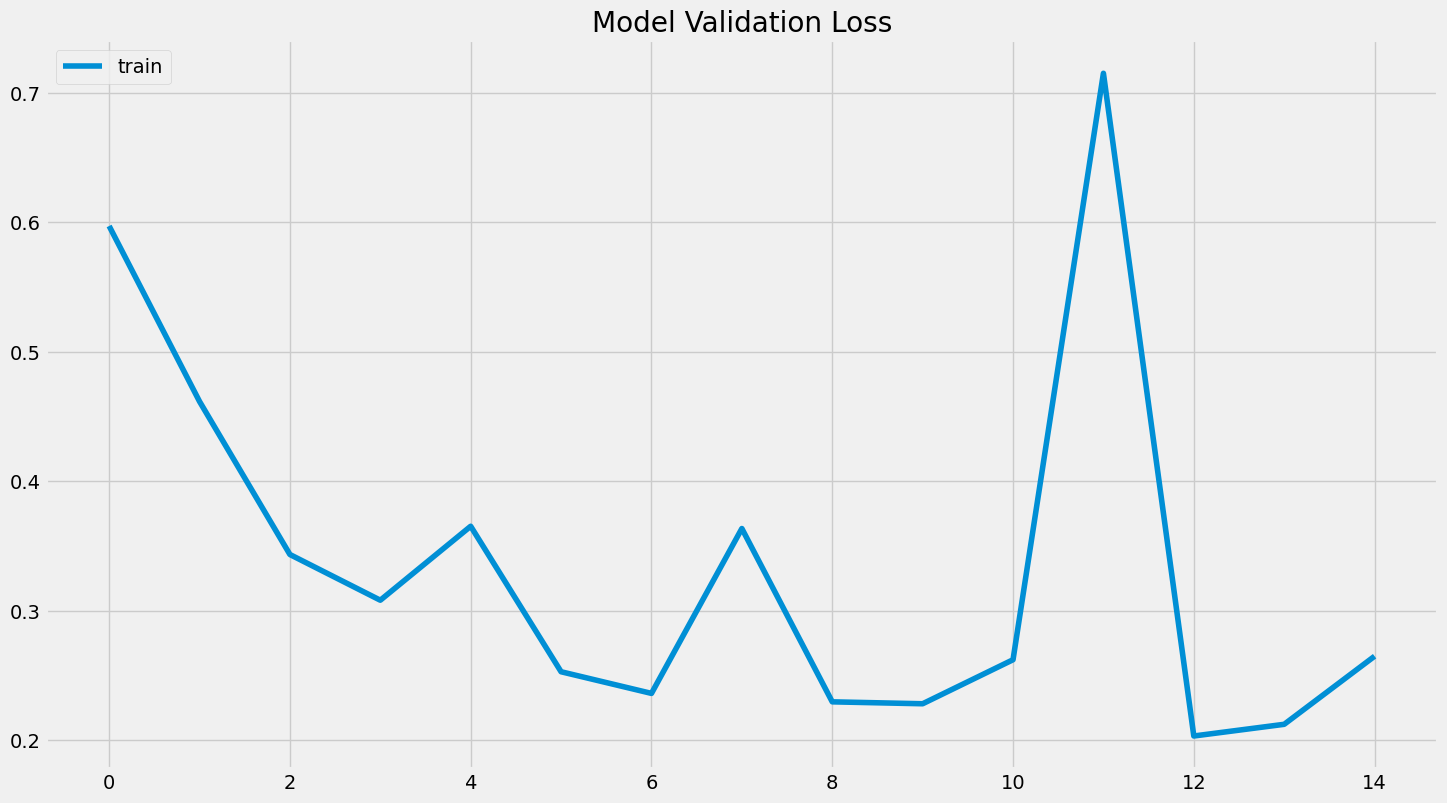

In [46]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [47]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 [==============================] - 118s 970ms/step


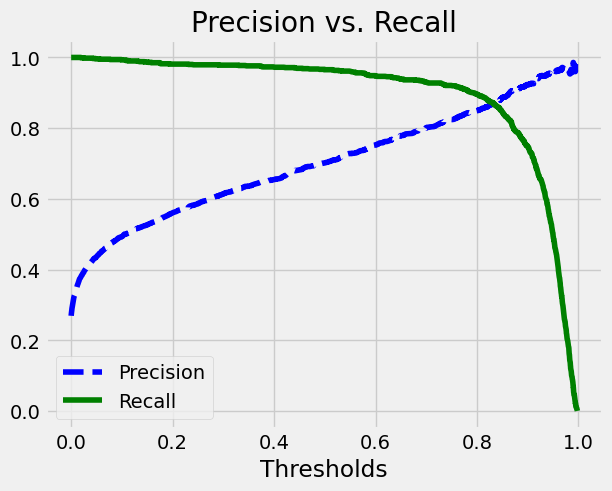

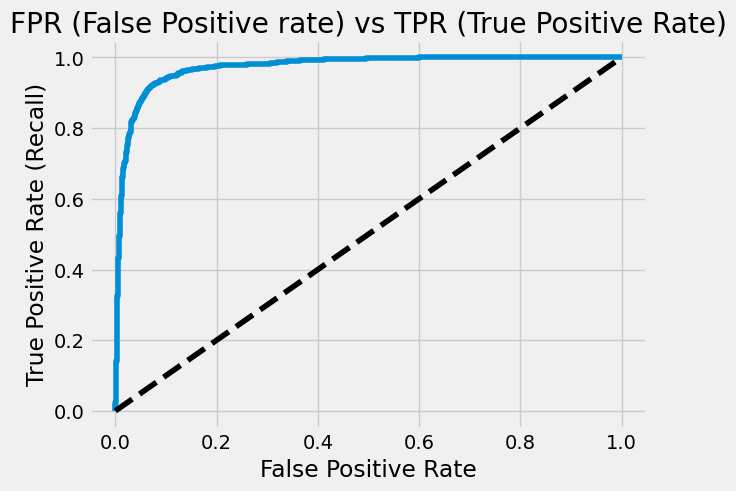

In [48]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)


In [49]:
predictions = model.predict(X_test)

37/37 [==============================] - 35s 939ms/step


In [50]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [51]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9163822525597269
Precision on testing set: 0.9544072948328267
Recall on testing set: 0.7909319899244333


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

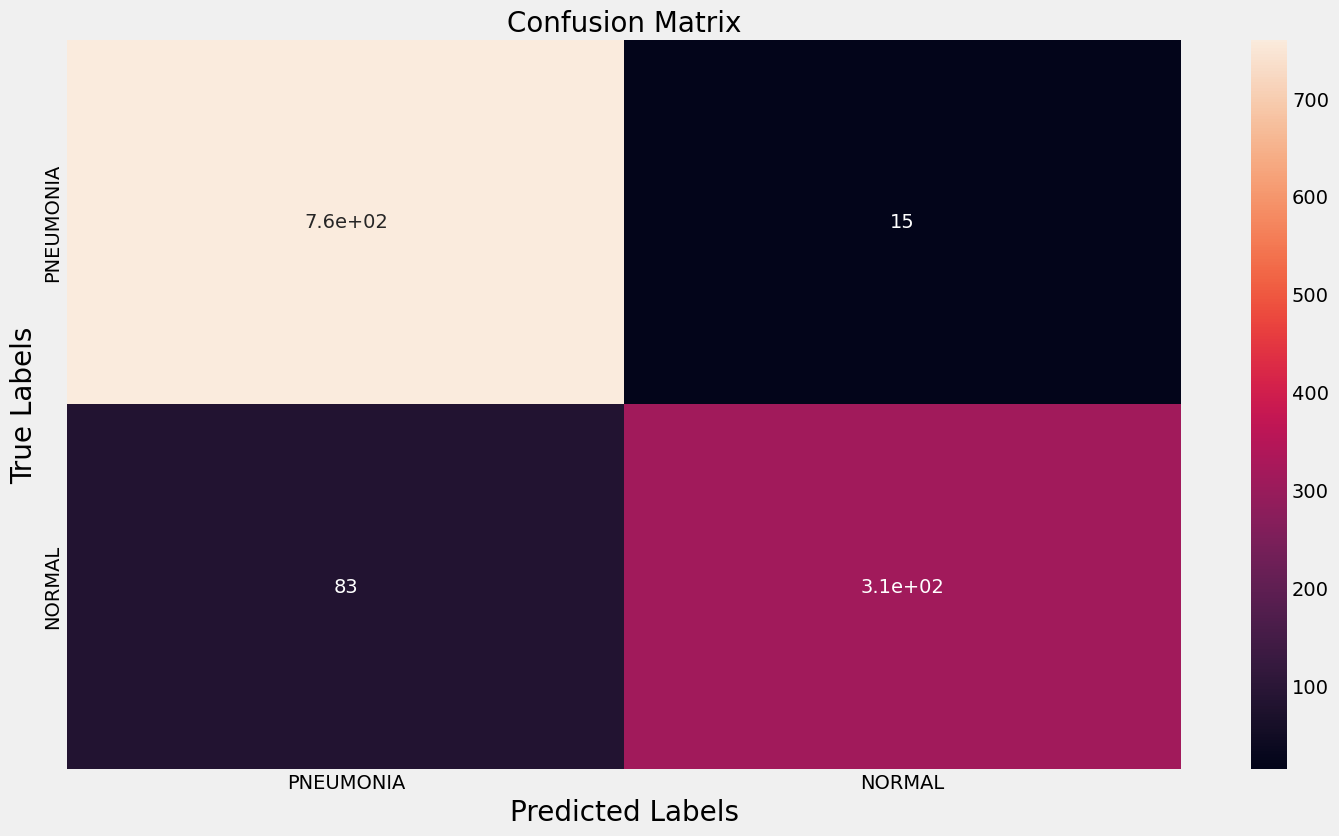

In [52]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

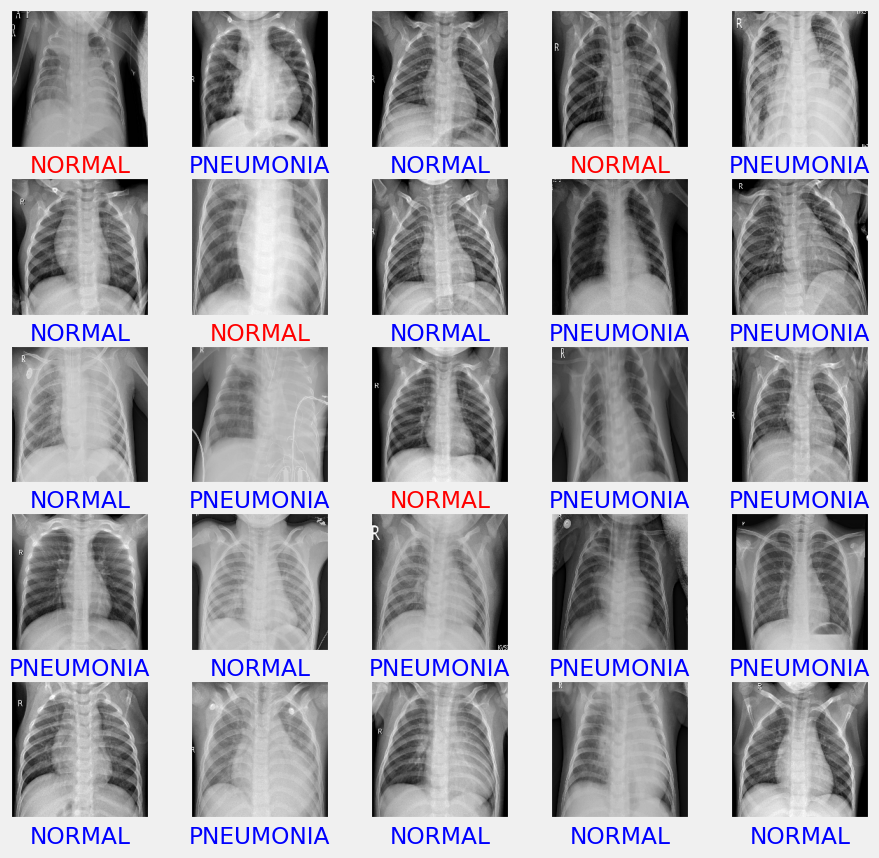

In [55]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

In [80]:
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk, Image

# Function to load and preprocess the image
# Function to load and preprocess the image
# Function to load and preprocess the image
# Function to load and preprocess the image
def load_image():
    global img_label, img, model, img_size
    file_path = filedialog.askopenfilename()
    if file_path:
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (150, 150))  # Resize image to match model's expected input shape
        img = img / 255.0  # Normalize

        # Ensure correct dimensions for the model input
        img_array = np.expand_dims(img, axis=-1)  # Add a channel dimension
        img_array = np.repeat(img_array, 3, axis=-1)  # Convert single channel to 3 channels
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        prediction = model.predict(img_array)
        if prediction[0][0] <= 0.5:
            result_label.config(text=f"Prediction: NORMAL")
        else:
            result_label.config(text=f"Prediction: PNEUMONIA")


root = tk.Tk()
root.title("Pneumonia Prediction")

# Image display label
img_label = tk.Label(root)
img_label.pack()

# Button to upload image
upload_button = tk.Button(root, text="Upload Image", command=load_image)
upload_button.pack()

# Label to show prediction result
result_label = tk.Label(root, text="")
result_label.pack()

root.mainloop()


1/1 [==============================] - 0s 31ms/step
